# SC3000 Lab 1: Balancing a Pole on a Cart

## Installing dependencies:
Run `pip install -r requirements.txt`. <br>
The `requirements.txt` file should be uploaded together with this project in the same directory as this jupyter notebook.

## Importing dependencies and define helper functions

In [1]:
import gym
from gym import logger as gymlogger
from gym.wrappers import RecordVideo
gymlogger.set_level(40) #error only
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else:
    print("Could not find video")

2024-03-27 16:46:39.845863: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-27 16:46:39.928085: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-27 16:46:40.552971: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-27 16:46:40.553229: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-27 16:46:40.749270: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

## Loading CartPole environment
We will be using the `gym` package for loading the cartpole environment.

In [2]:
env = gym.make("CartPole-v1")

We can check the action and observation space of this environment. Discrete(2) means that there are two valid discrete actions: 0 & 1.

In [3]:
print(env.action_space)

Discrete(2)


The observation space is given below. The first two arrays define the min and max values of the 4 observed values, corresponding to cart position, velocity and pole angle, angular velocity.

In [4]:
print(env.observation_space)

Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)


We call each round of the pole-balancing game an "episode". At the start of each episode, make sure the environment is reset, which chooses a random initial state, e.g., pole slightly tilted to the right. This initialization can be achieved by the code below, which returns the observation of the initial state.

In [5]:
observation = env.reset()
print("Initial observations:", observation)

Initial observations: [-0.02942512  0.03627444  0.03756242 -0.03394539]


For the CartPole environment, there are two possible actions: 0 for pushing to the left and 1 for pushing to the right. For example, we can push the cart to the left using code below, which returns the new observation, the current reward, an indicator of whether the game ends, and some additional information (not used in this project). For CartPole, the game ends when the pole is significantly tilted or you manage to balance the pole for 500 steps. You get exactly 1 reward for each step before the game ends (i.e., max cumulative reward is 500).

In [6]:
observation, reward, done, info = env.step(0)
print("New observations after choosing action 0:", observation)
print("Reward for this step:", reward)
print("Is this round done?", done)

New observations after choosing action 0: [-0.02869963 -0.15936548  0.03688351  0.27034822]
Reward for this step: 1.0
Is this round done? False


/home/yuhaopro/sc3000-project/.venv/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


# Q-Learning approach
---
$Q$-learning is a model-free reinforcement learning algorithm used to learn the value of an action in a particular state without requiring a model of the environment. It works by estimating the values of action-state pairs, represented as 
$Q(s,a)$. The core idea of $Q$-learning is to iteratively update the 
$Q$ values towards the expected returns, which are estimated based on the rewards observed and the future rewards anticipated, following an optimal policy. The update rule in $Q$-learning reflects this idea and is designed to minimize the difference between the current $Q$ value estimate and the "target" value that the 
$Q$ value is expected to converge to in the long run.

## Update Equation
---
$$Q_{new}(S_t,A_t) \leftarrow Q_{old}(S_t,A_t)+\alpha(R_{t+1}+\gamma maxQ_{old}(S_{t+1},\alpha)-Q_{old}(S_t,A_t))$$

## Methodology
---
- Discretize initial state space
- Model Training
- Model Evaluation

## - Discretize initial state space


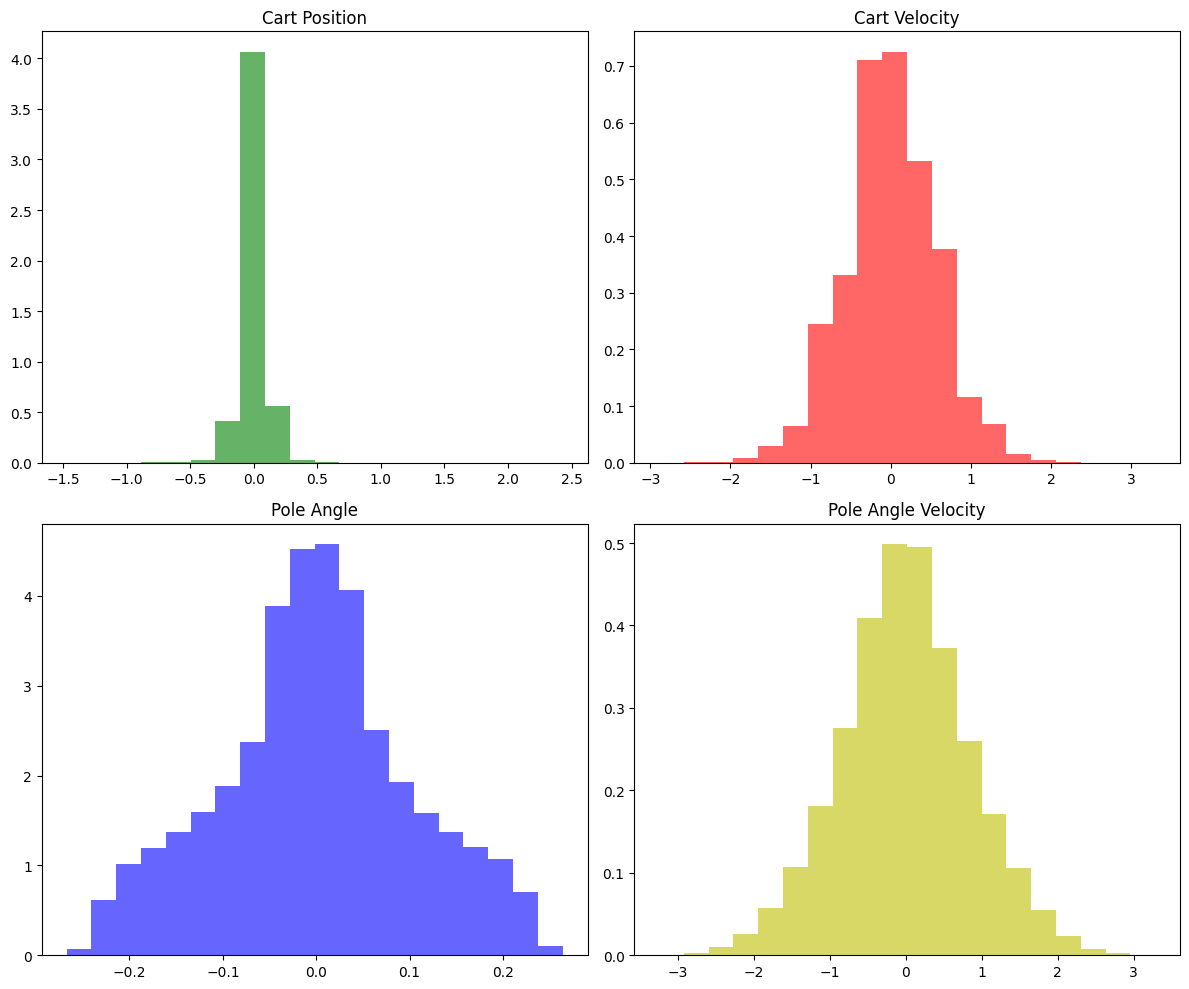

In [7]:
# To find out how we should split the observation space
# run 10000 episodes and plot the cart positions on a graph.

def plot_sample_data():
    pos = []
    pos_vel = []
    rad = []
    rad_vel = []

    for _ in range(10000):
        observation = env.reset()
        done = False
        while not done:
            action = env.action_space.sample()
            observation, reward, done, info = env.step(action)
            
            pos.append(observation[0])
            pos_vel.append(observation[1])
            rad.append(observation[2])
            rad_vel.append(observation[3])
            
    # Convert lists to numpy arrays
    pos = np.array(pos)
    pos_vel = np.array(pos_vel)
    rad = np.array(rad)
    rad_vel = np.array(rad_vel)

    # Directly using matplotlib for plotting
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    axs[0, 0].hist(pos, bins=20, density=True, alpha=0.6, color='g')
    axs[0, 0].set_title('Cart Position')

    axs[0, 1].hist(pos_vel, bins=20, density=True, alpha=0.6, color='r')
    axs[0, 1].set_title('Cart Velocity')

    axs[1, 0].hist(rad, bins=20, density=True, alpha=0.6, color='b')
    axs[1, 0].set_title('Pole Angle')

    axs[1, 1].hist(rad_vel, bins=20, density=True, alpha=0.6, color='y')
    axs[1, 1].set_title('Pole Angle Velocity')

    plt.tight_layout()
    plt.show()
    
    return pos, pos_vel, rad, rad_vel

pos, pos_vel, rad, rad_vel = plot_sample_data()


### Baseline Hypothesis
We tried to perform $Q$-learning by dividing the original state space into roughly 10 bins. However, this led to a problem where during training, the RL agent always perform the same action because the number of bins over the continuous space covers too little, and so we needed to optimize the division of state spaces based on the distribution of that particular state property.

Based on the state distributions we calculated over $10000$ episodes above and some testing, we can roughly bound the state space to the following values.<br>

$$-2.4<Cart Position<2.4$$
$$-4<Cart Velocity<4$$
$$-0.2095<Pole Angle<0.2095$$
$$-4<Pole Angle Velocity<4$$

Take note that these bounding values should not exceed the termination state conditions, as the terminal states for the episode to end should be the last state in the discretization process. <br>

You may find that some of the values do not strictly follow the distribution earlier, and that is because we found that during model training it was not performing as well as using the terminal states as the bounding values.

We incrementally use 10, 15, 20, 25 bins for the discretization, and found that 20 bins was the most suitable number in terms of training time and memory usage. 

In [8]:
# Create the discretized state space
# Initial hypothesis to split the state space into 20 discrete bins.
# use the range for the episode is still alive
bins = 20
pos_bins = np.linspace(-2.4, 2.4, bins)
pos_vel_bins = np.linspace(-4, 4, bins)
rad_bins = np.linspace(-.2095, .2095, bins)
rad_vel_bins = np.linspace(-4, 4, bins)
print(pos_bins, pos_vel_bins, rad_bins, rad_vel_bins)


[-2.4        -2.14736842 -1.89473684 -1.64210526 -1.38947368 -1.13684211
 -0.88421053 -0.63157895 -0.37894737 -0.12631579  0.12631579  0.37894737
  0.63157895  0.88421053  1.13684211  1.38947368  1.64210526  1.89473684
  2.14736842  2.4       ] [-4.         -3.57894737 -3.15789474 -2.73684211 -2.31578947 -1.89473684
 -1.47368421 -1.05263158 -0.63157895 -0.21052632  0.21052632  0.63157895
  1.05263158  1.47368421  1.89473684  2.31578947  2.73684211  3.15789474
  3.57894737  4.        ] [-0.2095     -0.18744737 -0.16539474 -0.14334211 -0.12128947 -0.09923684
 -0.07718421 -0.05513158 -0.03307895 -0.01102632  0.01102632  0.03307895
  0.05513158  0.07718421  0.09923684  0.12128947  0.14334211  0.16539474
  0.18744737  0.2095    ] [-4.         -3.57894737 -3.15789474 -2.73684211 -2.31578947 -1.89473684
 -1.47368421 -1.05263158 -0.63157895 -0.21052632  0.21052632  0.63157895
  1.05263158  1.47368421  1.89473684  2.31578947  2.73684211  3.15789474
  3.57894737  4.        ]


## Model Training
Here we will use the discretized state space to initialize the $Q$ table.

Take note that we have to add `+1` when initializing the $Q$ table because the `linspace` function defaults to using an endpoint which gives an extra state.

There are 4 main parameters that need to be defined in $Q$ Learning.
- `learning_rate` -> how much should the learned information be updated in each iteration
- `discount_factor` -> how much should future reward weigh in the update
- `epsilon` -> what is the probability of choosing exploration over exploitation
- `epsilon_decay` -> how much should the probability decrease after each iteration (rate of moving to exploitation from exploration)

The `model_training` function below uses these parameters and plug it into the $Q$ learning update algorithm. Actions are chosen either randomly or by selecting the highest Q-value action, depending on an epsilon-greedy strategy. The Q-table is updated based on the observed rewards, with adjustments made for future expected rewards, learning rate, and discount factor. Training continues until the average reward over the last 100 episodes reaches a target of 500, which would indicate that the model is able to successfully balance the cart pole for the entire episode.

In [15]:
def model_training():
# Initialize the Q table with zeros
# get the number of actions that can be performed at each state.
    num_actions = env.action_space.n
    q_table = np.zeros((bins+1, bins+1, bins+1, bins+1, num_actions))
    # q_table = np.zeros((num_bins, num_bins, num_bins, num_bins, num_actions))


    # Define the Q-learning parameters
    learning_rate = 0.1
    discount_factor = 0.99
    epsilon = 1
    epsilon_decay = 0.0001
    episodes = 0
    episode_rewards = []
    
    # Perform training
    while True:
        # reset to new episode for training
        observation = env.reset()
        
        # Discretize the observation to get the state
        pos, pos_vel, rad, rad_vel = observation
        env_pos = np.digitize(pos, pos_bins)
        env_pos_vel = np.digitize(pos_vel, pos_vel_bins)
        env_rad = np.digitize(rad, rad_bins)
        env_rad_vel = np.digitize(rad_vel, rad_vel_bins)
        
        done = False
        cumulative_reward = 0
        
        while not done:
            if np.random.uniform() < epsilon:
                action = env.action_space.sample()
            else:
                # obtain the action with the highest Q value
                action = np.argmax(q_table[env_pos, env_pos_vel, env_rad, env_rad_vel])
                
            # Perform the action
            new_observation, reward, done, info = env.step(action)
            new_env_pos = np.digitize(new_observation[0], pos_bins)
            new_env_pos_vel = np.digitize(new_observation[1], pos_vel_bins)
            new_env_rad = np.digitize(new_observation[2], rad_bins)
            new_env_rad_vel = np.digitize(new_observation[3], rad_vel_bins)
            
            q_table[env_pos, env_pos_vel, env_rad, env_rad_vel, action] += learning_rate * (
                reward + discount_factor * np.max(q_table[new_env_pos, new_env_pos_vel, new_env_rad, new_env_rad_vel]) -
                q_table[env_pos, env_pos_vel, env_rad, env_rad_vel, action]
            )
            
            # update the state
            env_pos = new_env_pos
            env_pos_vel = new_env_pos_vel
            env_rad = new_env_rad
            env_rad_vel = new_env_rad_vel
            
            # after each successful round, we add the reward gained
            cumulative_reward += reward
        
        # increment to next episode
        episodes += 1

        
        # calculate the mean reward over the last 100 episodes
        episode_rewards.append(cumulative_reward)
        mean_episode_rewards = np.mean(episode_rewards[len(episode_rewards)-100:])
        print(f"Episode {episodes} finished with reward {cumulative_reward} and epsilon {epsilon} and mean reward {mean_episode_rewards}")            
        if (mean_episode_rewards)==500:
            break
        
        #epsilon - epsilon_decay
        epsilon = max(epsilon * (1 - epsilon_decay), 0)
    # print(q_table)
    return q_table

This line of code initiates the training process of the Q-learning model by calling the `model_training` function, which iteratively improves the Q-table based on interactions with the environment. The resulting Q-table, optimized for making decisions within the given environment, is stored in `q_table_2`. This table will be used by our RL agent later on.

In [16]:
q_table_2 = model_training()

Episode 1 finished with reward 34.0 and epsilon 1 and mean reward 34.0
Episode 2 finished with reward 36.0 and epsilon 0.9999 and mean reward 35.0
Episode 3 finished with reward 28.0 and epsilon 0.9998000100000001 and mean reward 32.666666666666664
Episode 4 finished with reward 32.0 and epsilon 0.9997000299990001 and mean reward 32.5
Episode 5 finished with reward 21.0 and epsilon 0.9996000599960002 and mean reward 30.2
Episode 6 finished with reward 54.0 and epsilon 0.9995000999900007 and mean reward 34.166666666666664
Episode 7 finished with reward 20.0 and epsilon 0.9994001499800017 and mean reward 32.142857142857146
Episode 8 finished with reward 11.0 and epsilon 0.9993002099650037 and mean reward 29.5
Episode 9 finished with reward 21.0 and epsilon 0.9992002799440072 and mean reward 28.555555555555557
Episode 10 finished with reward 25.0 and epsilon 0.9991003599160128 and mean reward 28.2
Episode 11 finished with reward 27.0 and epsilon 0.9990004498800211 and mean reward 28.09090

## Task 1: Development of an RL agent

An example of a naive agent is given below, which randomly chooses an action regardless of the observation:

In [ ]:
def rand_policy_agent(observation):
    return random.randint(0, 1)

Here we define our $Q$ learning agent which uses the `digitize` function to map the environment values to one of the bins we defined for that environment property earlier on using `linspace`.

In [ ]:
def q_learning_agent(observation):
    pos, pos_vel, rad, rad_vel = observation
    env_pos = np.digitize(pos, pos_bins)
    env_pos_vel = np.digitize(pos_vel, pos_vel_bins)
    env_rad = np.digitize(rad, rad_bins)
    env_rad_vel = np.digitize(rad_vel, rad_vel_bins)
    return np.argmax(q_table_2[env_pos, env_pos_vel, env_rad, env_rad_vel])

For Task 1, we can show the observation and chosen action below:<br>

As a sanity check the initial observation below shows that the pole is tilting to the right, and the cart is moving left. Thus the chosen action is to move the cart right to ensure that the pole does not fall more towards the right. Based on our agent, it made the right choice.

In [ ]:
observation = env.reset()
print("Initial observation:", observation)
action = q_learning_agent(observation)
print("Chosen action:", action)
next_observation, reward, done, info = env.step(action)
print("New observation:", next_observation)

Initial observation: [-0.04604036 -0.00995594  0.02563705  0.03134791]
Chosen action: 1
New observation: [-0.04623948  0.18478915  0.026264   -0.2531373 ]


With a working $Q$ learning agent, we can then define a `run_episodes` 
function that can take in the number of episodes which we wish to test for the agent and store it's performance based on cumulative reward per episode into a list to be displayed in a line chart later on for Task 2.

For each episode, it initializes the environment, then repeatedly selects actions based on the current state until the episode ends. It accumulates rewards throughout the episode, tracking the total reward per episode. Finally, it returns an array of the cumulative rewards from all episodes, allowing for evaluation of the agent's performance.

In [ ]:
def run_episodes(no_of_episodes, agent):
    cumulative_rewards = []
    for episode in range(no_of_episodes):
        observation = env.reset()
        done = False
        cumulative_reward = 0
        while not done:
            action = agent(observation)
            next_observation, reward, done, info = env.step(action)
            cumulative_reward += reward
            observation = next_observation
        print("Episode", episode, "Cumulative reward", cumulative_reward)
        cumulative_rewards.append(cumulative_reward)
    return np.array(cumulative_rewards)

## Task 2: Demonstrate the effectiveness of the RL agent

We then run 100 episodes of a simulation using the `run_episodes` function with the `q_learning_agent` as the decision-making agent. It stores the cumulative rewards for each episode in `episode_results`. After running the episodes, it prints the array of cumulative rewards, providing insight into the agent's performance across episodes.

Finally, it plots these cumulative rewards against the episode number, displaying the agent's learning progress over time with a graph titled 'Cumulative reward for each episode'. This plot helps to visualize improvements or consistency in the agent's ability to accumulate rewards over time.

In [ ]:
# run 100 episodes
episode_results = run_episodes(100, q_learning_agent)
print("total_episode", episode_results)

Episode 0 Cumulative reward 500.0
Episode 1 Cumulative reward 500.0
Episode 2 Cumulative reward 500.0
Episode 3 Cumulative reward 500.0
Episode 4 Cumulative reward 500.0
Episode 5 Cumulative reward 500.0
Episode 6 Cumulative reward 500.0
Episode 7 Cumulative reward 500.0
Episode 8 Cumulative reward 500.0
Episode 9 Cumulative reward 500.0
Episode 10 Cumulative reward 500.0
Episode 11 Cumulative reward 500.0
Episode 12 Cumulative reward 500.0
Episode 13 Cumulative reward 500.0
Episode 14 Cumulative reward 500.0
Episode 15 Cumulative reward 500.0
Episode 16 Cumulative reward 500.0
Episode 17 Cumulative reward 500.0
Episode 18 Cumulative reward 500.0
Episode 19 Cumulative reward 500.0
Episode 20 Cumulative reward 500.0
Episode 21 Cumulative reward 500.0
Episode 22 Cumulative reward 500.0
Episode 23 Cumulative reward 500.0
Episode 24 Cumulative reward 500.0
Episode 25 Cumulative reward 500.0
Episode 26 Cumulative reward 500.0
Episode 27 Cumulative reward 500.0
Episode 28 Cumulative reward 5

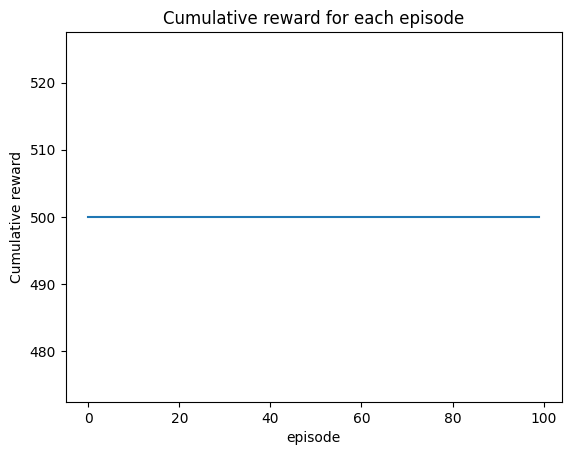

In [ ]:

plt.plot(episode_results)
plt.title('Cumulative reward for each episode')
plt.ylabel('Cumulative reward')
plt.xlabel('episode')
plt.show()

Based on the line graph, our $Q$ learning agent was able to successfully balance the cart pole for the full duration of the episode. Let's print the average reward over the 100 episodes.

In [ ]:
print("Average cumulative reward:", episode_results.mean())
print("Is my agent good enough?", episode_results.mean() > 195)

Average cumulative reward: 500.0
Is my agent good enough? True


## Task 3: Render one episode played by the agent

Plug your agent to the code below to obtain rendered result.

In [ ]:
env = RecordVideo(gym.make("CartPole-v1"), "./video")
observation = env.reset()
while True:
    env.render()
    #your agent goes here
    action = q_learning_agent(observation)
    observation, reward, done, info = env.step(action)
    if done:
      break
env.close()
show_video()

/home/yuhaopro/sc3000-project/.venv/lib/python3.10/site-packages/imageio_ffmpeg/_utils.py:7: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_filename
/home/yuhaopro/sc3000-project/.venv/lib/python3.10/site-packages/pkg_resources/__init__.py:2846: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('mpl_toolkits')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/home/yuhaopro/sc3000-project/.venv/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


# Conclusion
Even though theoretically $Q$ learning may not have been the best approach for cart pole since it has a continuous environment and thus becomes difficult to discretize, by observing the distribution trend of the environment properties and trying it out different bounding values, our model is able to successfully balance the pole in over $25000$ episodes. Future improvement could be to look at the use of Deep Q Learning (DQN) to reduce the number of episodes required for training the agent. 